## ptCLM_NEON
#### Plots simulated vs. observed ratiation, energy fluxes & GPP at tower sites
- Will Wieder
- Created Sept 20, 2020

In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
from ctsm_py import utils
from scipy import signal,stats

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

### Point to files

In [2]:
site  = 'HARV'
case  = 'clm50bgcNEON_'+site
years = [2018,2019]
nmon  = 12
OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NEON/'+site+'/'
OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
#print(OBSfile)

CLMdir = '/glade/scratch/wwieder/archive/'+case+'/lnd/hist/'
CLMfile = [CLMdir + case +'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' for i in range(len(years)) ]  
CLMfile

['/glade/scratch/wwieder/archive/clm50bgcNEON_HARV/lnd/hist/clm50bgcNEON_HARV.clm2.h1.2018-01-01-00000.nc',
 '/glade/scratch/wwieder/archive/clm50bgcNEON_HARV/lnd/hist/clm50bgcNEON_HARV.clm2.h1.2019-01-01-00000.nc']

### Read in dataset 
- get rid of extra dimensions
- remove CLM time shift, here -2, not -1?

In [3]:
dsOBS = utils.time_set_mid(xr.open_mfdataset(OBSfile, decode_times=True, combine='by_coords'), 'time')
dsCLM = xr.open_mfdataset(CLMfile, decode_times=True, combine='by_coords')

dsOBS = dsOBS.isel(lat=0, lon=0)
dsCLM = dsCLM.isel(lndgrid=0)

dsCLM = dsCLM.shift(time=-2)

In [4]:
# create new variables to subset data
dsOBS['month']  = dsOBS['time.month']
dsOBS['season'] = dsOBS['time.season']
dsCLM['month']  = dsCLM['time.month']
dsCLM['season'] = dsCLM['time.season']

# calculate Rnet from absorbed - reflected radiation
dsCLM['Rnet'] = dsCLM.FSA - dsCLM.FIRA	
dsCLM['Rnet'].attrs['units'] = dsCLM.FSA.attrs['units']
dsCLM['Rnet'].attrs['long_name'] = 'net radiation'

In [5]:
# convert obs GPP units from umol/m2/s to g/m2/h
# assumes NEON results are umolC (not CO2) m^-2 s^-1
dsOBS['GPP'] = dsOBS.GPP * 1e-6 * 12.01 * 3600
dsOBS['GPP'].attrs['units'] = 'gC/m2/h'
# convert clm GPP units from g/m2/s to g/m2/h
dsCLM['GPP'] = dsCLM.GPP * 3600
dsCLM['GPP'].attrs['units'] = 'gC/m2/h'

### Plots of seasonal data

In [6]:
Var = ['Rnet','FSH','EFLX_LH_TOT','GPP']
Season = ['DJF','MAM','JJA','SON']

Text(0.85, 0.9, 'r = 0.95')

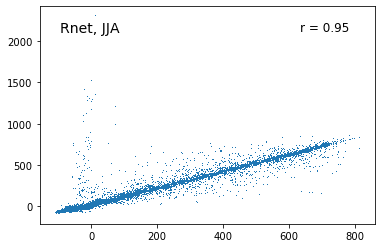

In [27]:
fig, ax = plt.subplots()

x, y = dsOBS[Var[0]].where(dsOBS.season==Season[2]).values, dsCLM[Var[0]].where(dsCLM.season==Season[2]).values

ax.plot(x, y,',')
line = mlines.Line2D([x.min(), x.max()], [x.min(), x.max()], color='k')
ax.add_line(line)
ax.text(0.15, 0.90,(Var[0]+', '+Season[2]), fontsize=14, ha='center', va='center', transform=plt.gca().transAxes);

# drop missing values from x,y
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
x = np.compress(bad, x)  
y = np.compress(bad, y) 

R, p = stats.pearsonr(x,y)
R = np.round(R, 2)
ax.text(0.85, 0.90,'r = '+str(R),fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)


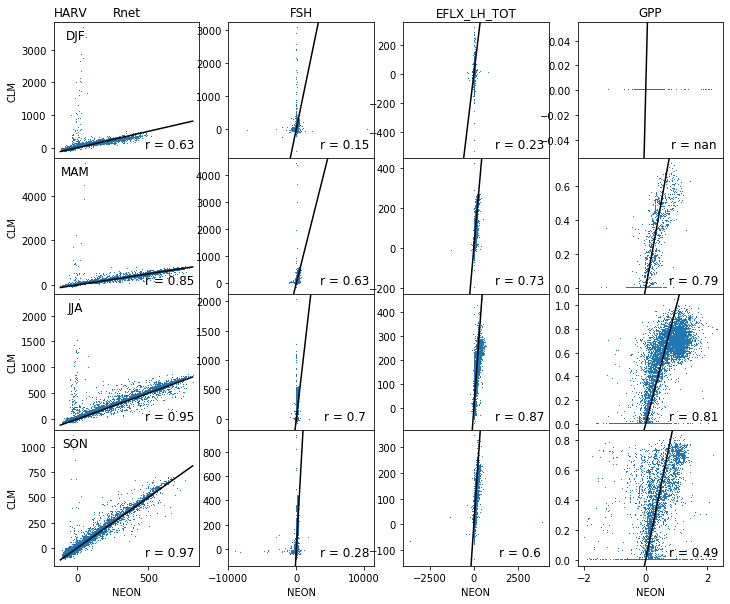

In [34]:
fig, axs = plt.subplots(len(Season), len(Var), sharex='col', #sharey='col',
                        gridspec_kw={'hspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    xmin = dsOBS[Var[v]].min()
    xmax = dsOBS[Var[v]].max()
    for i in range(len(Season)):
        x = dsOBS[Var[v]].where(dsOBS.season==Season[i]).values
        y = dsCLM[Var[v]].where(dsCLM.season==Season[i]).values
        axs[i,v].plot(x, y,',')
        line = mlines.Line2D([xmin, xmax], [xmin, xmax], color='k')
        axs[i,v].add_line(line)

        # add stats
        bad = ~np.logical_or(np.isnan(x), np.isnan(y))
        x = np.compress(bad, x)  
        y = np.compress(bad, y) 
        R, p = stats.pearsonr(x,y)
        R = np.round(R, 2)
        axs[i,v].text(0.8, 0.1,'r = '+str(R),fontsize=12, 
                     ha='center', va='center', transform=axs[i,v].transAxes)

        # control titles & axis labels
        # label colums of data with variables name
        if i == 0: 
            axs[i, v].set_title(Var[v])
            if v == 0:
                axs[i, v].set_title(site, loc='left')

        # x-axis lables on bottom row of plots
        if i == 3: 
            axs[i, v].set_xlabel('NEON')
        
        # y axis labels and seasons in left column
        if v == 0:
            axs[i,v].set_ylabel('CLM')
            axs[i,v].text(0.15, 0.90,(Season[i]), fontsize=12, ha='center', va='center', 
                transform=axs[i,v].transAxes)

### Plot annual cycle, raw & averaged

<Figure size 504x648 with 0 Axes>

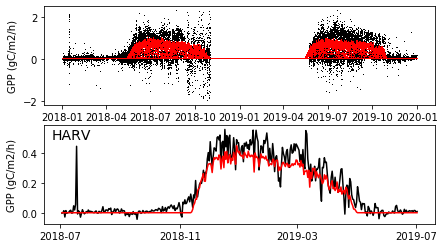

In [9]:
# quick plot of GPP 
plt.figure(figsize=(7, 9))
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(7, 4) )#,sharey=True)
fig.subplots_adjust(wspace=0.3)

ax1.plot(dsOBS.time, dsOBS.GPP,',', color='k')
ax1.plot(dsOBS.time, dsCLM.GPP,',', color='r')
ax1.set_ylabel('GPP ('+dsCLM.GPP.attrs['units']+')')
ax1.text(0.9, 0.1,site, fontsize=14,
                 ha='center', va='center', transform=plt.gca().transAxes);

# mean daily data
ax2.plot(dsCLM.time.groupby('time.dayofyear').mean(), dsOBS.GPP.groupby('time.dayofyear').mean(), color='k')
ax2.plot(dsCLM.time.groupby('time.dayofyear').mean(), dsCLM.GPP.groupby('time.dayofyear').mean(), color='r')
ax2.set_ylabel('GPP ('+dsCLM.GPP.attrs['units']+')')
ax2.text(0.07, 0.90,site, fontsize=14,
                 ha='center', va='center', transform=plt.gca().transAxes);

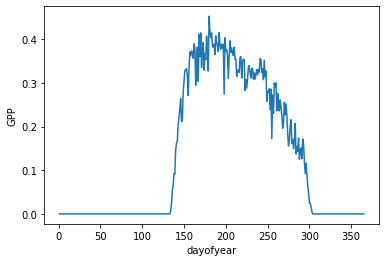

In [10]:
temp = dsCLM.GPP.groupby('time.dayofyear').mean()
temp.plot()

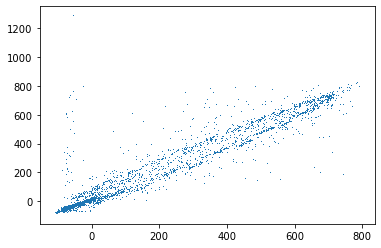

<xarray.DataArray 'time' (time: 35039)>
array([cftime.DatetimeNoLeap(2018, 1, 1, 0, 30, 0, 53, 2, 1),
       cftime.DatetimeNoLeap(2018, 1, 1, 1, 0, 0, 107, 2, 1),
       cftime.DatetimeNoLeap(2018, 1, 1, 1, 30, 0, 0, 2, 1), ...,
       cftime.DatetimeNoLeap(2019, 12, 31, 22, 30, 0, 0, 3, 365),
       cftime.DatetimeNoLeap(2019, 12, 31, 22, 59, 58, 242187, 3, 365),
       cftime.DatetimeNoLeap(2019, 12, 31, 23, 30, 1, 757812, 3, 365)],
      dtype=object)
Coordinates:
  * time     (time) object 2018-01-01 00:30:00 ... 2019-12-31 23:30:01
Attributes:
    long_name:  time
    bounds:     time_bounds

<xarray.Dataset>
Dimensions:       (hist_interval: 2, levdcmp: 25, levgrnd: 25, levlak: 10, levsoi: 20, time: 35040)
Coordinates:
  * time          (time) object 2018-01-01 00:00:00 ... 2019-12-31 23:30:01
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.325 44.775
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 ... 28.870724 41.998436
Dimensions without coordinates: hist_interval, levsoi
Data variables:
    mcdate        (time) float64 dask.array<chunksize=(35040,), meta=np.ndarray>
    mcsec         (time) float64 dask.array<chunksize=(35040,), meta=np.ndarray>
    mdcur         (time) float64 dask.array<chunksize=(35040,), meta=np.ndarray>
    mscur         (time) float64 dask.array<chunksize=(35040,), meta=np.ndarray>
    nstep         (time) float64 dask.array<chunksize=(35040,), meta=np.ndarray>
    time_bounds   (time, hist_interval) object dask.array<chunksize=(35040, 2), meta=np.ndarray>
    date_written  (time) object dask.array<chunksize=(35040,), meta=np.ndarray>
    time_written  (time) object dask.array<chunksize=(35040,), meta=np.ndarray>
    lon           float32 dask.array<chunksize=(), meta=np.ndarray>
    lat           float32 dask.array<chunksize=(), meta=np.ndarray>
    area          float32 dask.array<chunksize=(), meta=np.ndarray>
    landfrac      float32 dask.array<chunksize=(), meta=np.ndarray>
    landmask      float64 dask.array<chunksize=(), meta=np.ndarray>
    pftmask       float64 dask.array<chunksize=(), meta=np.ndarray>
    nbedrock      float64 dask.array<chunksize=(), meta=np.ndarray>
    ZSOI          (levgrnd) float32 dask.array<chunksize=(25,), meta=np.ndarray>
    DZSOI         (levgrnd) float32 dask.array<chunksize=(25,), meta=np.ndarray>
    WATSAT        (levgrnd) float32 dask.array<chunksize=(25,), meta=np.ndarray>
    SUCSAT        (levgrnd) float32 dask.array<chunksize=(25,), meta=np.ndarray>
    BSW           (levgrnd) float32 dask.array<chunksize=(25,), meta=np.ndarray>
    HKSAT         (levgrnd) float32 dask.array<chunksize=(25,), meta=np.ndarray>
    ZLAKE         (levlak) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    DZLAKE        (levlak) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    AGNPP         (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    AR            (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    BGNPP         (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    BTRANMN       (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    COSZEN        (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    EFLX_LH_TOT   (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    ELAI          (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FCEV          (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FCTR          (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FGEV          (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FGR           (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FGR12         (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FIRA          (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FIRE          (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FLDS          (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FPI           (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FPSN          (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FSA           (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FSDS          (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FSH           (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FSH_G         (time) float32 dask.array<chunksize=(35040,), meta=np.ndarray>
    FSM  

In [78]:
dsCLM['time'] = dsCLM.time[1:]


ValueError: conflicting sizes for dimension 'time': length 35040 on 'mcdate' and length 35039 on 'time'